In [1]:
import akshare as ak 

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os 
from datetime import datetime

Matplotlib is building the font cache; this may take a moment.


In [8]:
STOCK_CODES = ["600519", "000858", "600938", "000333", "601088", "300866", "600900", "600036", "300750", "601899", "603993"]
STOCK_SYMBOLS_1 = ["sh" + code if code.startswith("6") else "sz" + code for code in STOCK_CODES ]
STOCK_SYMBOLS_2 = [code + ".SH" if code.startswith("6") else code + ".SZ" for code in STOCK_CODES ]

today = pd.to_datetime("today").strftime("%Y%m%d")

### load bps, eps, roe

In [29]:
for stock_code in STOCK_CODES:
    try: 
        print(f"Processing stock code: {stock_code}")
        # --- get the financial data ---
        financial_df = ak.stock_financial_abstract_ths(symbol=f"{stock_code}", indicator="按单季度")
        # select the key indicators
        financial_df = financial_df[['报告期', '每股净资产', '基本每股收益', '净资产收益率']]
        # rename the columns
        financial_df.columns = ['report_date', 'bps', 'eps', 'roe']
        # chage the date format
        financial_df['report_date'] = pd.to_datetime(financial_df['report_date'])
        # choose the date later than 2010-01-01
        financial_df = financial_df[financial_df['report_date'] >= '2010-01-01']
        # change the data format
        financial_df['eps'] = financial_df['eps'].astype(float)
        financial_df['roe'] = financial_df['roe'].str.replace('%', '').astype(float)
        financial_df['bps'] = financial_df['bps'].astype(float)
        # calculate ttm eps and ttm roe
        financial_df['bps_ttm'] = financial_df['bps'].rolling(window=4).mean()
        financial_df['eps_ttm'] = financial_df['eps'].rolling(window=4).sum()
        financial_df['roe_ttm'] = financial_df['roe'].rolling(window=4).sum()
        # drop the values with null values
        print("original shape: ", financial_df.shape)
        financial_df.dropna(inplace=True)
        print("shape after dropping rows with null values: ", financial_df.shape)
        
        # --- merge the financial data with standardized report dates ---
        # standardize the report dates
        date_df = pd.DataFrame(pd.date_range(start='2010-12-31', end='2025-12-31', freq='ME'), columns=['report_date'])
        financial_date = pd.merge(date_df, financial_df, on='report_date', how='left', validate="1:1")
        print("The number of null values: ", financial_date.isna().sum().sum())
        print("The merged shape: ", financial_date.shape)
        financial_date.to_csv(f"../data/input/financial_indicators_{stock_code}_{today}.csv", index=False)
        print('--' * 50)
    except: 
        print(f"Failed to get the financial indicators for {stock_code}")
        print('--' * 50)
        continue



Processing stock code: 300750
original shape:  (35, 7)
shape after dropping rows with null values:  (28, 7)
The number of null values:  918
The merged shape:  (181, 7)
----------------------------------------------------------------------------------------------------
Processing stock code: 601899
original shape:  (63, 7)
shape after dropping rows with null values:  (60, 7)
The number of null values:  726
The merged shape:  (181, 7)
----------------------------------------------------------------------------------------------------
Processing stock code: 603993
original shape:  (59, 7)
shape after dropping rows with null values:  (50, 7)
The number of null values:  786
The merged shape:  (181, 7)
----------------------------------------------------------------------------------------------------


### load price

In [30]:
for stock_symbol in STOCK_SYMBOLS_1:
    try: 
        # --- get the price data ---
        # price_df = ak.stock_zh_a_hist(symbol=f"{stock_code}", period="monthly", start_date="20101231", end_date=f"{today}", adjust="")
        price_df = ak.stock_zh_a_daily(symbol=f"{stock_symbol}", start_date="20101231", end_date="20251231", adjust="")
        price_df = price_df[['date', 'open', 'high', 'low', 'close']]
        price_df.columns = ['report_date', 'open', 'high', 'low', 'close']
        print("The price shape with price df: ", price_df.shape)
        price_df.to_csv(f"../data/input/price_data_{stock_symbol}_{today}.csv", index=False)
        print('--' * 50)
    except: 
        print(f"Failed to get the stock price for {stock_symbol}")
        print('--' * 50)
        continue

The price shape with price df:  (1823, 5)
----------------------------------------------------------------------------------------------------
The price shape with price df:  (3597, 5)
----------------------------------------------------------------------------------------------------
The price shape with price df:  (3181, 5)
----------------------------------------------------------------------------------------------------


### merge and calculate

In [22]:
for stock_code, stock_symbol in zip(STOCK_CODES, STOCK_SYMBOLS_1):
    financial_date = pd.read_csv(f"../data/input/financial_indicators_{stock_code}_{today}.csv")
    price_df = pd.read_csv(f"../data/input/price_data_{stock_symbol}_{today}.csv")
    # --- merge the price data with financial data ---
    financial_date['report_date'] = pd.to_datetime(financial_date['report_date'])
    price_df['report_date'] = pd.to_datetime(price_df['report_date'])
    financial_date['year'] = financial_date['report_date'].dt.year
    financial_date['month'] = financial_date['report_date'].dt.month
    price_df['year'] = price_df['report_date'].dt.year
    price_df['month'] = price_df['report_date'].dt.month
    # aggregate the daily price into monthly price
    price_month = price_df.groupby(['year', 'month']).agg({'open': 'first', 'close': 'last', 
                                                       'high': 'max', 'low': 'min'}).reset_index()
    
    financial_price = pd.merge(price_month, financial_date, on=['year', 'month'], how='left', validate="1:1")
    financial_price = financial_price.ffill()

    # --- calculate pe_ttm, pb_ttm, pr_ttm ---
    financial_price['pe_ttm'] = financial_price['close'] / financial_price['eps_ttm']
    financial_price['pb_ttm'] = financial_price['close'] / financial_price['bps_ttm']
    financial_price['pr_ttm'] = financial_price['pe_ttm'] / financial_price['roe_ttm']
    financial_price['update_date'] = today
    print("The final shape: ", financial_price.shape)
    financial_price.to_csv(f"../data/processed/stock_valuation_{stock_code}_{today}.csv", index=False)
    print('--' * 50)


The final shape:  (181, 17)
----------------------------------------------------------------------------------------------------
The final shape:  (178, 17)
----------------------------------------------------------------------------------------------------
The final shape:  (45, 17)
----------------------------------------------------------------------------------------------------
The final shape:  (148, 17)
----------------------------------------------------------------------------------------------------
The final shape:  (179, 17)
----------------------------------------------------------------------------------------------------
The final shape:  (65, 17)
----------------------------------------------------------------------------------------------------
The final shape:  (177, 17)
----------------------------------------------------------------------------------------------------
The final shape:  (181, 17)
-----------------------------------------------------------------------

### visulization

In [23]:
import matplotlib.font_manager as fm
[f.name for f in fm.fontManager.ttflist if "PingFang" in f.name or "Heiti" in f.name]

['Heiti TC', 'Heiti TC']

In [24]:
plt.rcParams['font.sans-serif'] = ['Heiti TC']

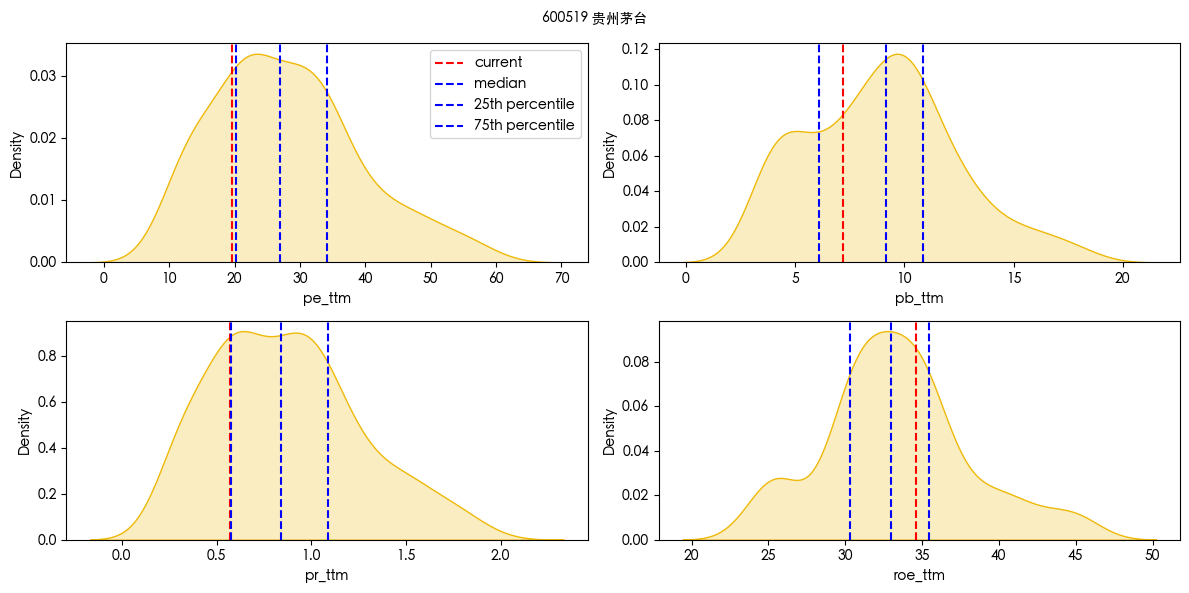

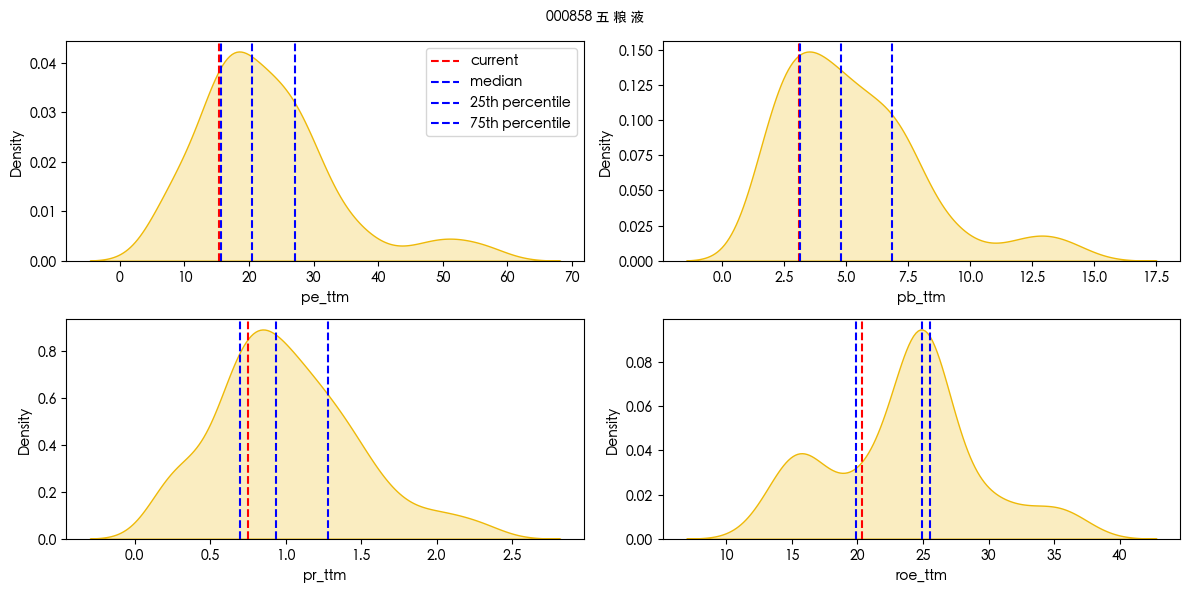

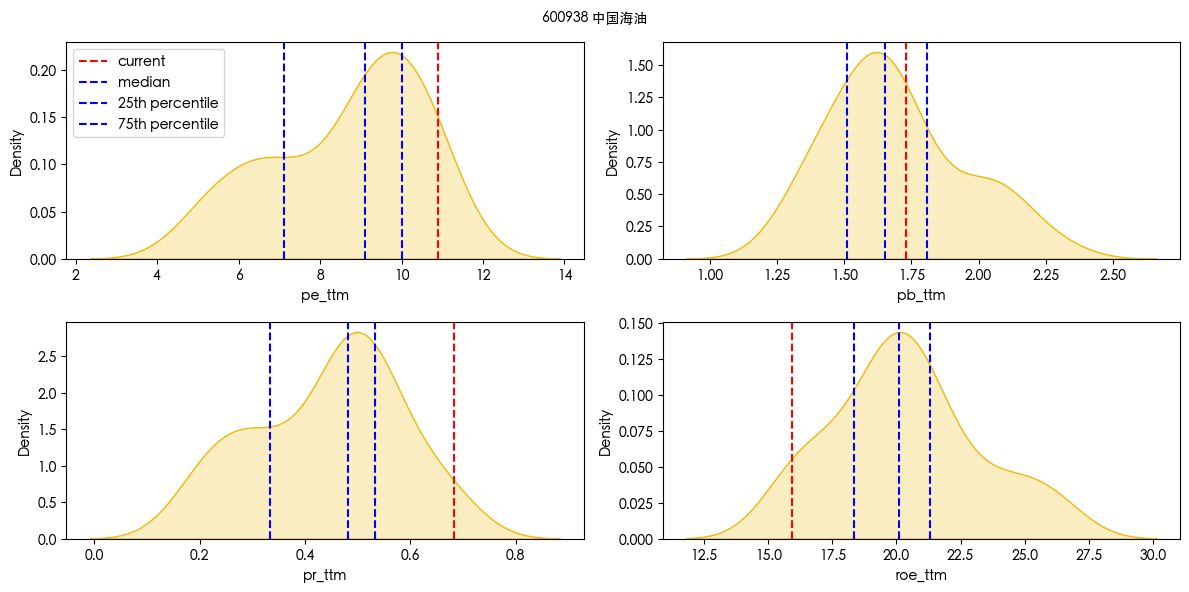

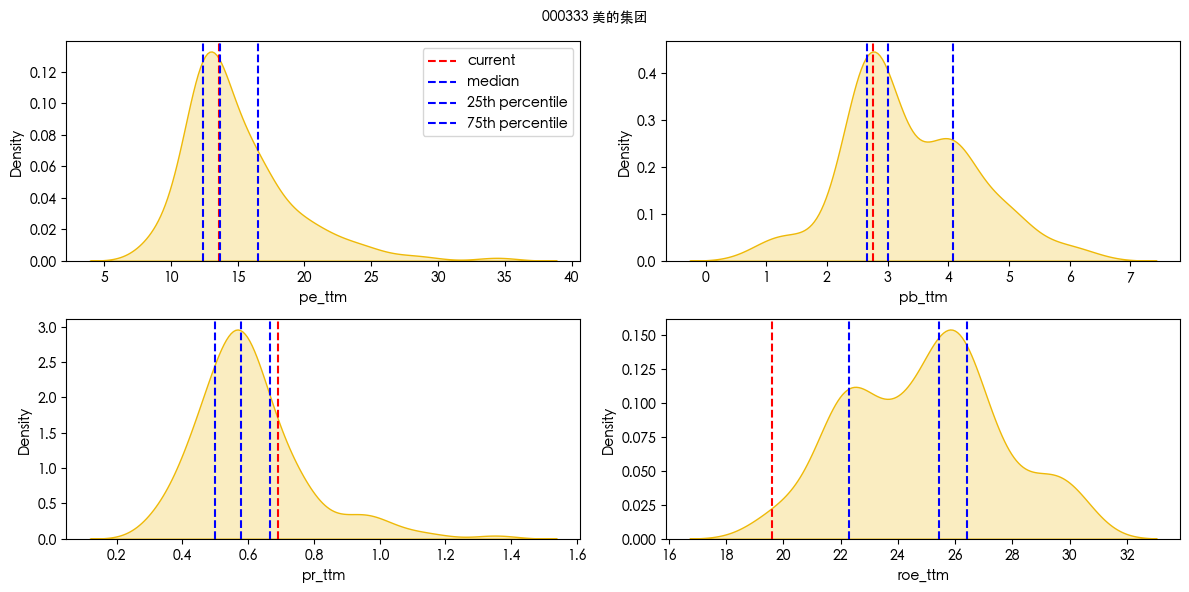

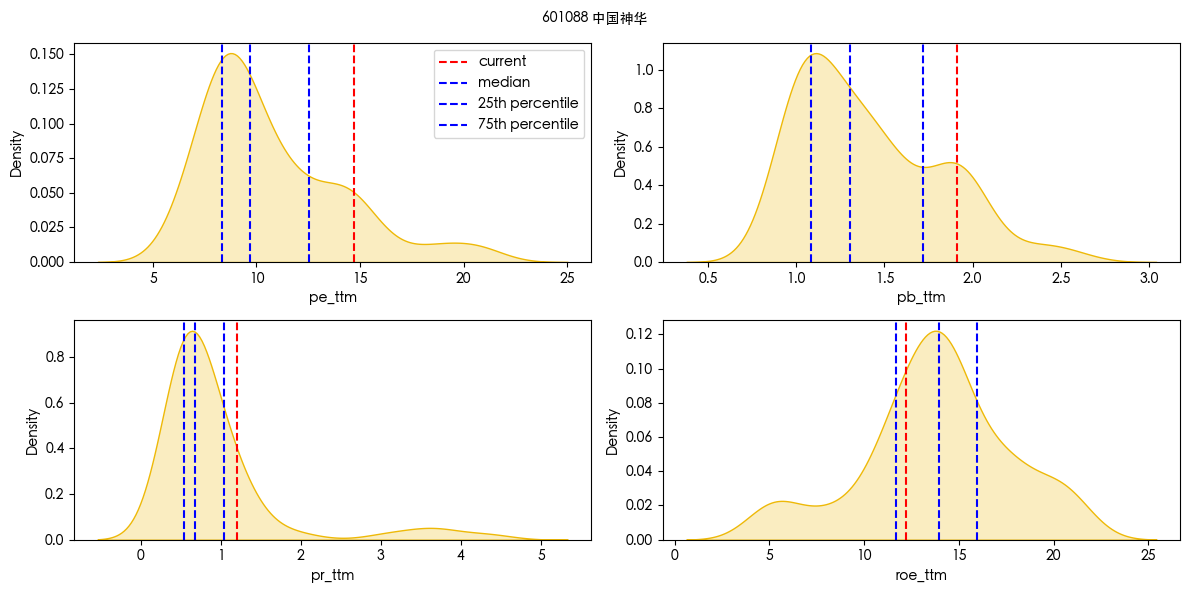

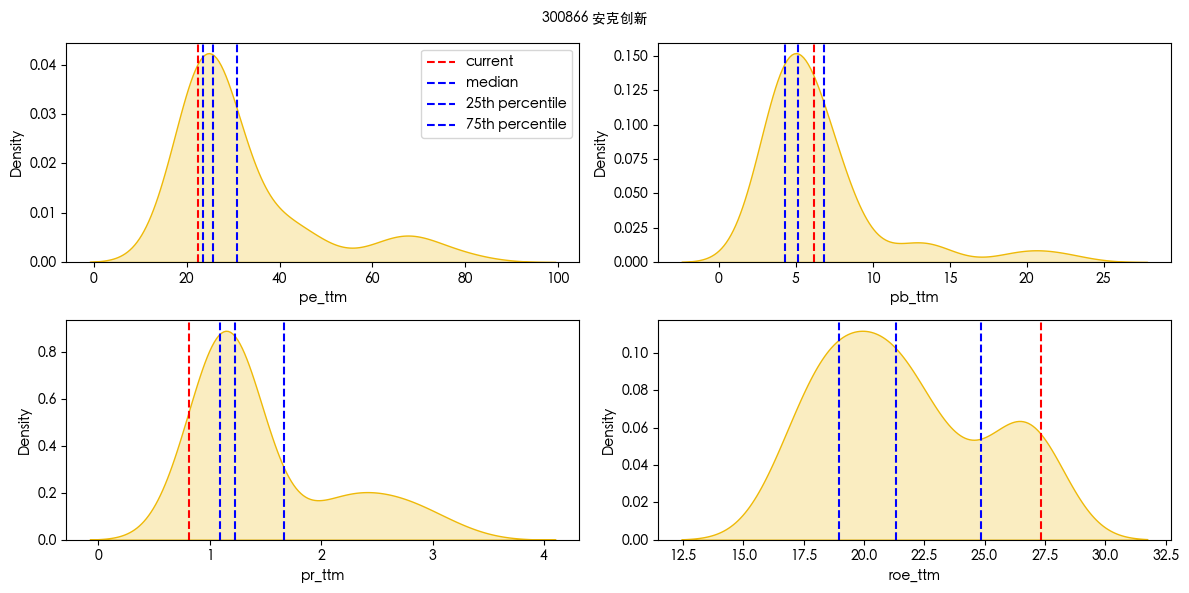

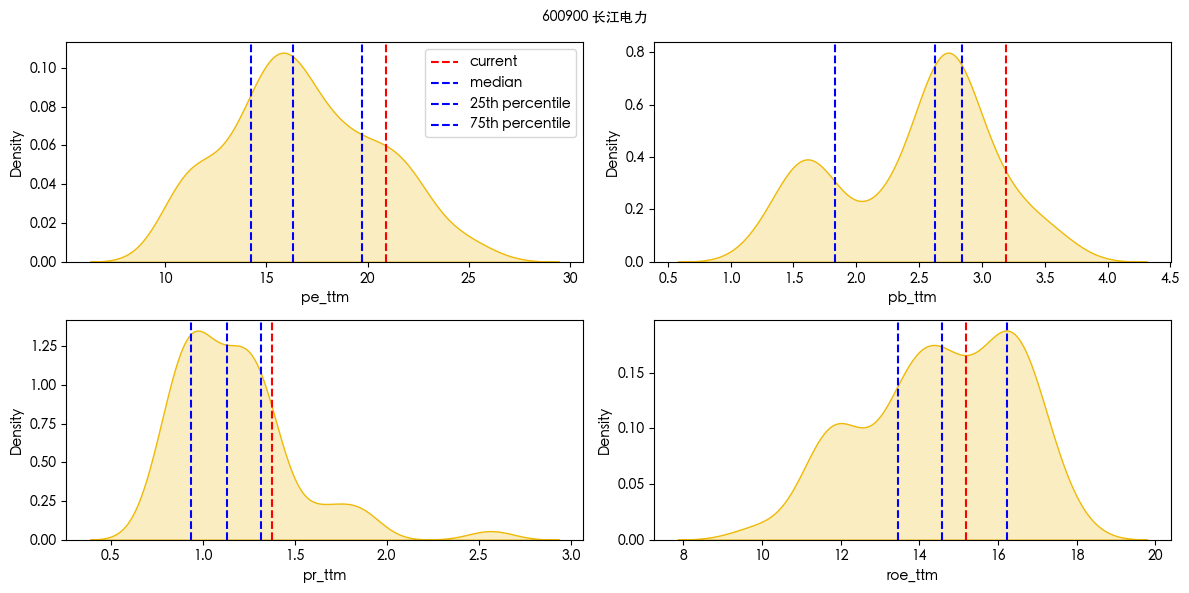

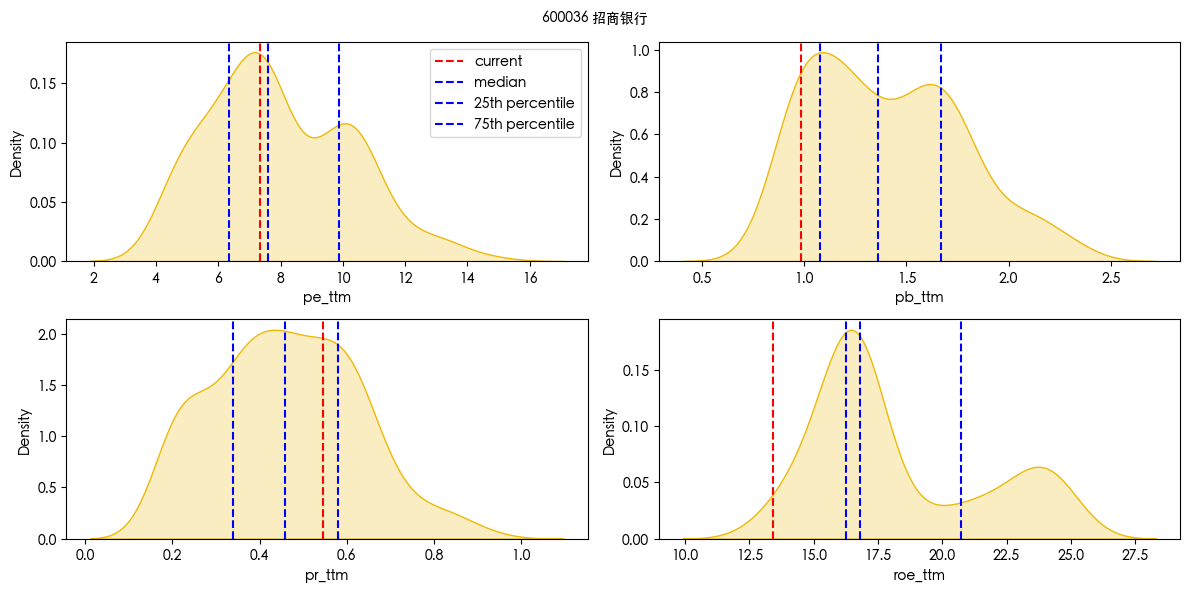

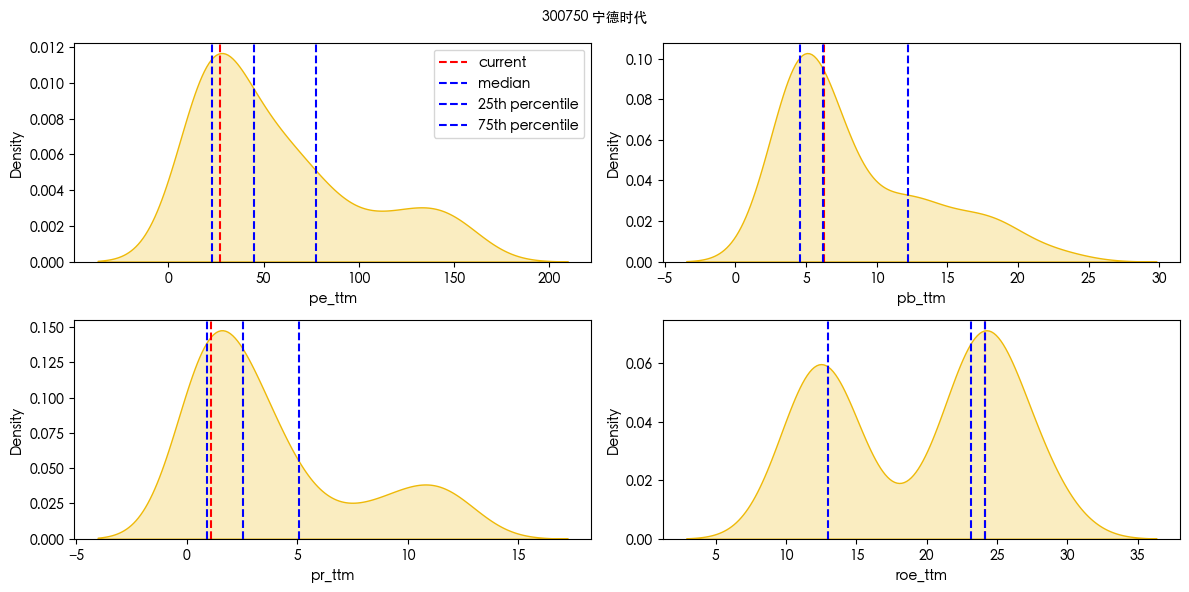

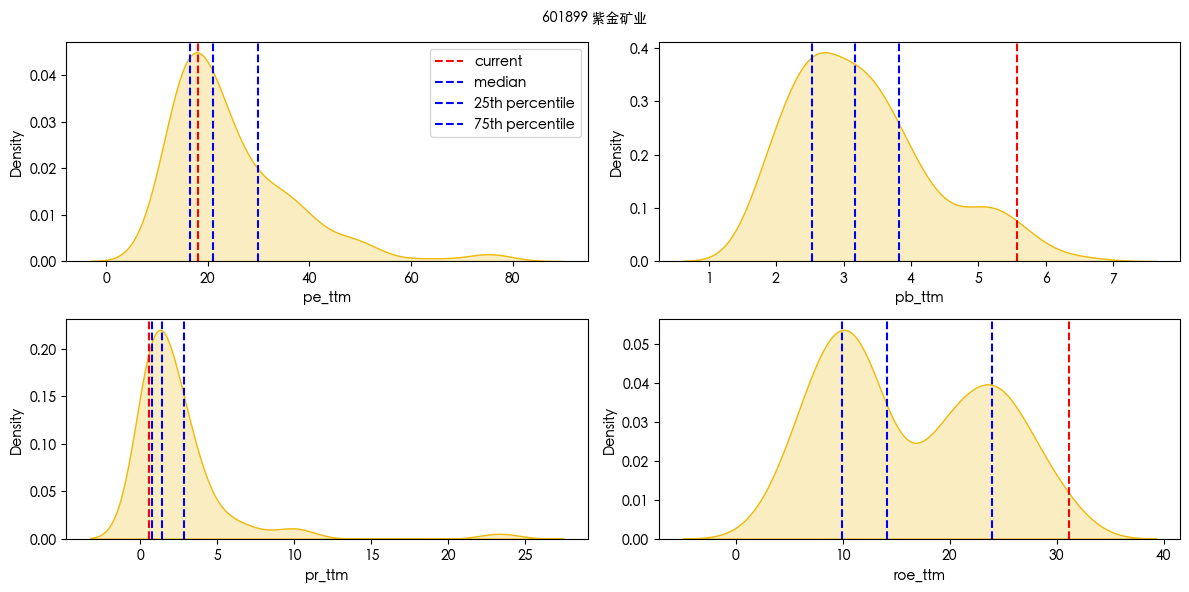

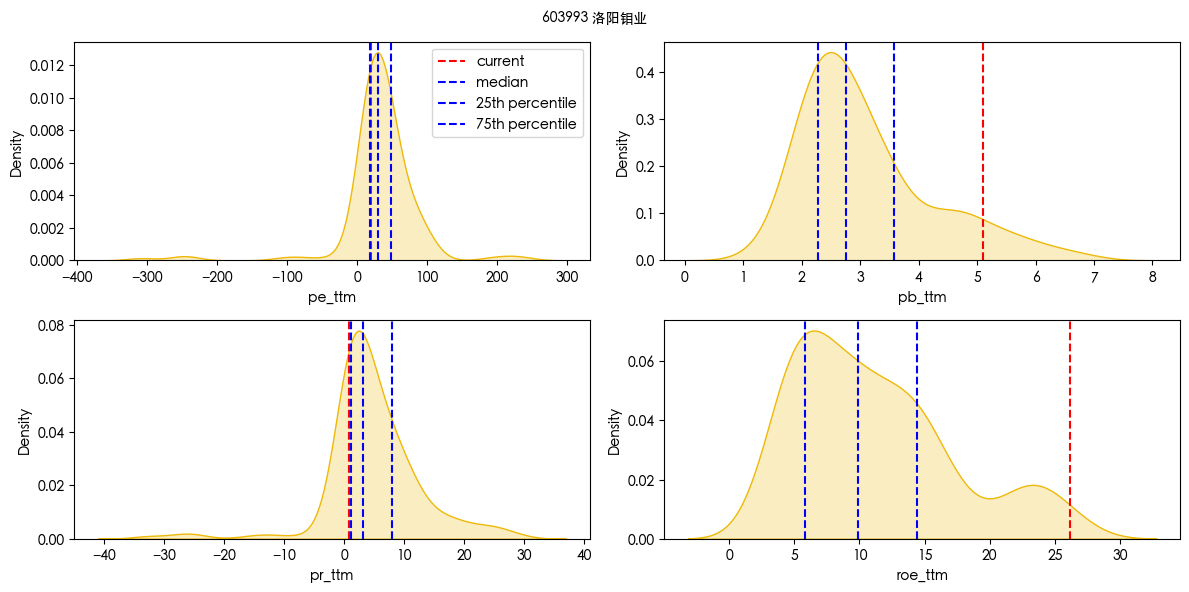

In [26]:
for stock_code in STOCK_CODES:
    financial_price = pd.read_csv(f"../data/processed/stock_valuation_{stock_code}_{today}.csv")

    fig, axes = plt.subplots(2, 2, figsize=(12, 6))
    axes = axes.flatten()

    # pe ttm distribution
    sns.kdeplot(financial_price, x='pe_ttm', fill=True, color="#eeb908", ax=axes[0])
    # current pe ttm
    axes[0].axvline(x=financial_price.iloc[-1, -4], color='red', linestyle='--', label='current')
    # median pettm
    axes[0].axvline(x=financial_price['pe_ttm'].median(), color='blue', linestyle='--', label='median')
    # 25th percentile
    axes[0].axvline(x=financial_price['pe_ttm'].quantile(0.25), color='blue', linestyle='--', label='25th percentile')
    # 75th percentile
    axes[0].axvline(x=financial_price['pe_ttm'].quantile(0.75), color='blue', linestyle='--', label='75th percentile')
    axes[0].legend()

    # pb ttm distribution
    sns.kdeplot(financial_price, x='pb_ttm', fill=True, color="#eeb908", ax=axes[1])
    # current pb ttm
    axes[1].axvline(x=financial_price.iloc[-1, -3], color='red', linestyle='--')
    # median pbttm
    axes[1].axvline(x=financial_price['pb_ttm'].median(), color='blue', linestyle='--')
    # 25th percentile
    axes[1].axvline(x=financial_price['pb_ttm'].quantile(0.25), color='blue', linestyle='--')
    # 75th percentile
    axes[1].axvline(x=financial_price['pb_ttm'].quantile(0.75), color='blue', linestyle='--')

    # pr ttm distribution
    sns.kdeplot(financial_price, x='pr_ttm', fill=True, color="#eeb908", ax=axes[2])
    # current pr ttm
    axes[2].axvline(x=financial_price.iloc[-1, -2], color='red', linestyle='--')
    # median prttm
    axes[2].axvline(x=financial_price['pr_ttm'].median(), color='blue', linestyle='--')
    # 25th percentile
    axes[2].axvline(x=financial_price['pr_ttm'].quantile(0.25), color='blue', linestyle='--')
    # 75th percentile
    axes[2].axvline(x=financial_price['pr_ttm'].quantile(0.75), color='blue', linestyle='--')

    # roe ttm distribution
    sns.kdeplot(financial_price, x='roe_ttm', fill=True, color="#eeb908", ax=axes[3])
    # current roe ttm
    axes[3].axvline(x=financial_price.iloc[-1, -5], color='red', linestyle='--')
    # median roettm
    axes[3].axvline(x=financial_price['roe_ttm'].median(), color='blue', linestyle='--')
    # 25th percentile
    axes[3].axvline(x=financial_price['roe_ttm'].quantile(0.25), color='blue', linestyle='--')
    # 75th percentile
    axes[3].axvline(x=financial_price['roe_ttm'].quantile(0.75), color='blue', linestyle='--')
    
    stock_names = pd.read_csv("../data/input/stock_names_full.csv")
    stock_name = stock_names[stock_names['code'] == int(stock_code)]['name'].values[0]
    fig.suptitle(f"{stock_code} {stock_name}", fontsize=10)
    plt.tight_layout()
    # plt.legend()
   
    # save the image
    plt.savefig(f"../img/pe_pb_pr_roe_distribution_monthly_close_{stock_code}_{today}.png", dpi=300)
    plt.show()